# Determinare se una prenotazione di hotel sarà cancellata o meno

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Federica Bedeschi  
`federica.bedeschi4@studio.unibo.it`

## Parte 1 - Obiettivo del modello e analisi del dataset

Si vuole realizzare un modello in grado di predire se una prenotazione di un hotel sarà cancellata o meno. Si tratta quindi di un problema di classificazione binaria.

In [292]:
# import librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Caricamento del dataset
*Fonte: Kaggle (https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)*

In [293]:
data = pd.read_csv("hotel_reservations.csv", index_col=0)

In [294]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Il dataset fa riferimento a una catena di hotel. Ogni riga rappresenta una prenotazione di una camera da parte di un cliente.

Come si può notare, l'indice (Booking_ID) è di fatto un numero progressivo, e non rispetta l'ordine cronologico delle date di prenotazione da parte dei clienti. Vedremo in seguito se questo sarà un problema per la divisione in training set e validation set ed eventualmente come risolverlo.

Le variabili presenti sono:
- no_of_adults: numero di adulti
- no_of_children: numero di bambini
- no_of_weekend_nights: numero di notti nel weekend (Sabato o Domenica) prenotate dal cliente
- no_of_week_nights: numero di notti infrasettimanali (da Lunedì a Venerdì) prenotate dal cliente
- type_of_meal_plan: tipo di piano dei pasti prenotato dal cliente ###### Type of meal plan booked by the customer
- required_car_parking_space: il cliente richiede il parcheggio auto? (0 - No, 1 - Sì)
- room_type_reserved: tipo di stanza prenotata dal cliente
- lead_time: numero di giorni tra la data di prenotazione e la data di arrivo in hotel
- arrival_year: anno della data di arrivo in hotel
- arrival_month: mese della data di arrivo in hotel
- arrival_date: giorno della data di arrivo in hotel
- market_segment_type: designazione del segmento di mercato (i.e. prenotazione effettuata online o offline)
- repeated_guest: il cliente è già stato ospite? (0 - No, 1 - Sì)
- no_of_previous_cancellations: numero di prenotazioni cancellate dal cliente prima della prenotazione corrente
- no_of_previous_bookings_not_canceled: numero di prenotazioni non cancellate dal cliente prima della prenotazione corrente
- avg_price_per_room: prezzo medio giornaliero della prenotazione (i prezzi delle camere sono dinamici)
- no_of_special_requests: numero di richieste speciali fatte dal cliente (ad esempio: piano alto, vista dalla camera, ecc)
- booking_status: indica se il cliente ha cancellato la prenotazione o meno (Canceled / Not_Canceled)

Quest'ultima è la variabile target da predire.

In [295]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_seg

Come si può notare dai conteggi, non sono presenti valori nulli, per cui non risulta necessario effettuare modifiche in tal senso.

Dividiamo ora le variabili in numeriche e categoriche, e mettiamo da parte quelle binarie:
- Variabili numeriche: no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights, lead_time, arrival_year, arrival_month, arrival_date, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, avg_price_per_room, no_of_special_requests
- Variabili categoriche: type_of_meal_plan, room_type_reserved, market_segment_type
- Variabili binarie: required_car_parking_space, repeated_guest

In [296]:
numeric_vars = ["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", "lead_time", "arrival_year",
                "arrival_month", "arrival_date", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled",
                "avg_price_per_room", "no_of_special_requests"]
categorical_vars = ["type_of_meal_plan", "room_type_reserved", "market_segment_type"]
binary_vars = ["required_car_parking_space", "repeated_guest"]

Le due variabili categoriche "type_of_meal_plan" e "room_type_reserved" sono memorizzate come object. Ricarichiamo quindi il dataframe specificando il tipo category per queste variabili.

In [297]:
data = pd.read_csv("hotel_reservations.csv",
                   index_col=0,
                   dtype={var: "category" for var in categorical_vars})

In [298]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   no_of_weekend_nights                  36275 non-null  int64   
 3   no_of_week_nights                     36275 non-null  int64   
 4   type_of_meal_plan                     36275 non-null  category
 5   required_car_parking_space            36275 non-null  int64   
 6   room_type_reserved                    36275 non-null  category
 7   lead_time                             36275 non-null  int64   
 8   arrival_year                          36275 non-null  int64   
 9   arrival_month                         36275 non-null  int64   
 10  arrival_date                          36275 non-null  int64   
 1

Come si può notare, ora le due variabili categoriche sono classificate correttamente.

## Parte 2 - Analisi esplorativa del dataset

### Analisi delle singole feature

In [299]:
data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


Così vediamo qualche dato utile, ma cerchiamo di esplorare più a fondo le variabili.
Iniziamo guardando la distribuzione della variabile target "booking_status".

In [300]:
data["booking_status"].value_counts()

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

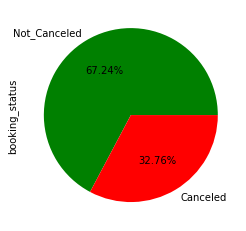

In [302]:
booking_status_colors = {"Not_Canceled": "green", "Canceled": "red"}
data["booking_status"].value_counts().plot.pie(autopct="%.2f%%", colors=booking_status_colors.values());

Si nota una distribuzione sbilanciata dei valori di booking_status. Occorrerà tenere conto di questo quando si modelleranno e valuteranno i modelli.

Andiamo ad analizzare meglio la distribuzione delle variabili utilizzando i grafici.

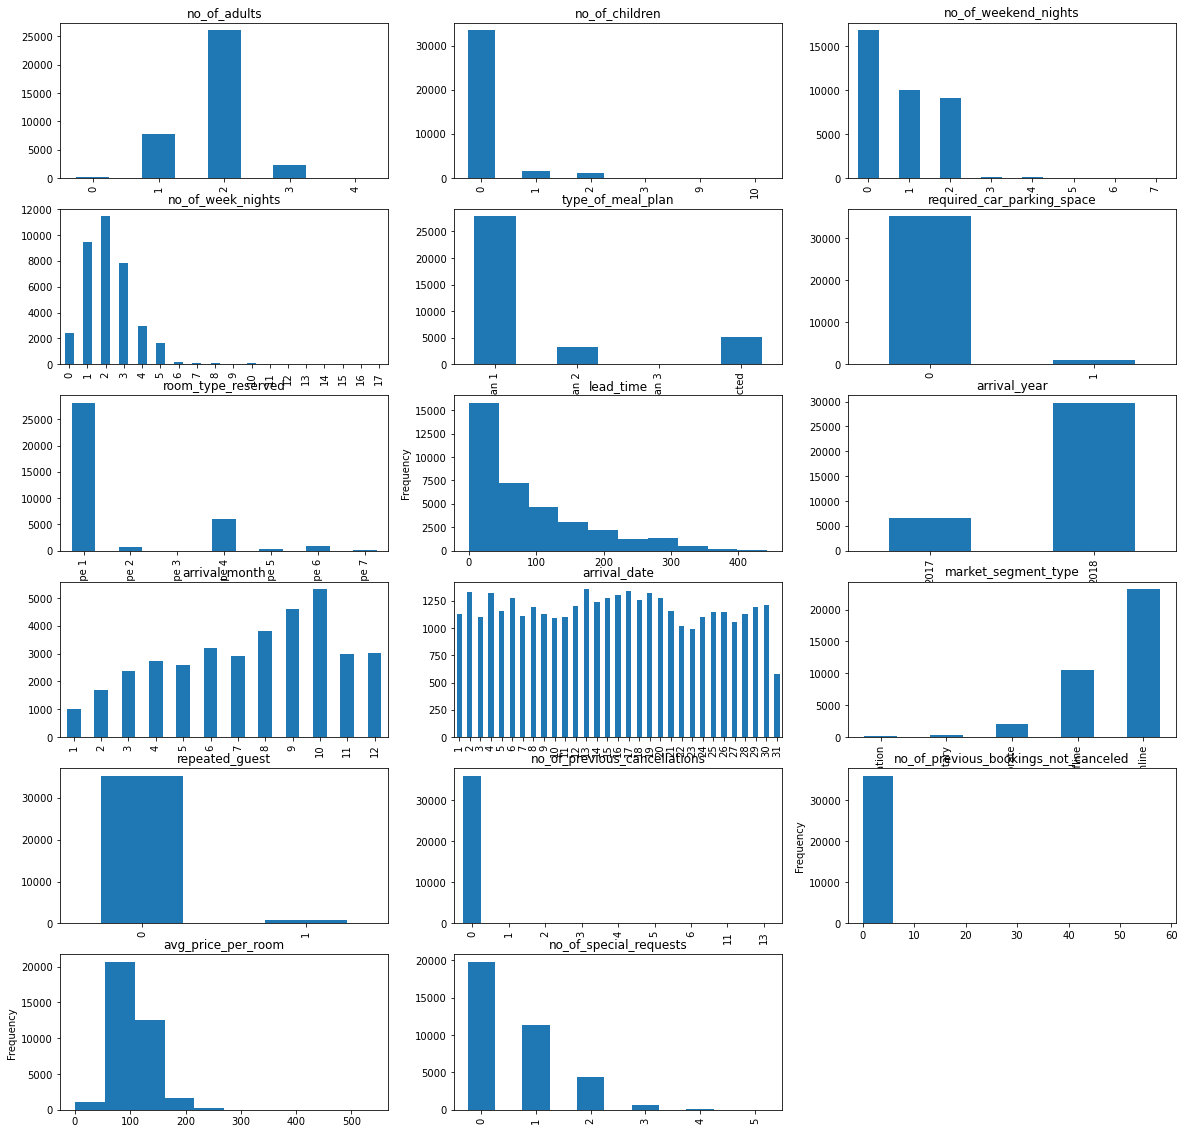

In [303]:
plt.figure(figsize=(20, 20))
for i, var in enumerate(data.columns.drop("booking_status"), start=1):
    if var in {"avg_price_per_room", "lead_time", "no_of_previous_bookings_not_canceled"}:
        data[var].plot.hist(ax=plt.subplot(6, 3, i), title=var)
    else:
        data[var].value_counts().sort_index().plot.bar(ax=plt.subplot(6, 3, i), title=var)

Notiamo ad esempio che la distribuzione di molte variabili è concentrata su un numero molto ristretto di valori.
In particolare, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, required_car_parking_space, repeated_guest e, seppur meno, no_of_children, hanno valore 0 quasi nella totalità dei casi, facendo supporre una probabile trascurabile influenza di queste variabili.

Analizziamo più in dettaglio la variabile continua avg_price_per_room.

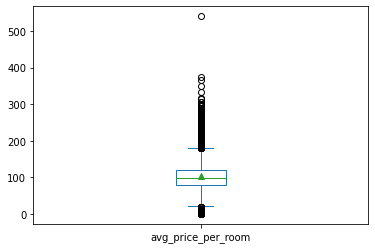

In [304]:
data["avg_price_per_room"].plot.box(showmeans=True);

Vediamo che ha una distribuzione normale, anche se con diversi outliers. PROBABILMENTE IL 500+ POTREBBE ESSERE ELIMINATO ???

Analizziamo ora la distribuzione di tutte le variabili evidenziando le due classi di predizione.

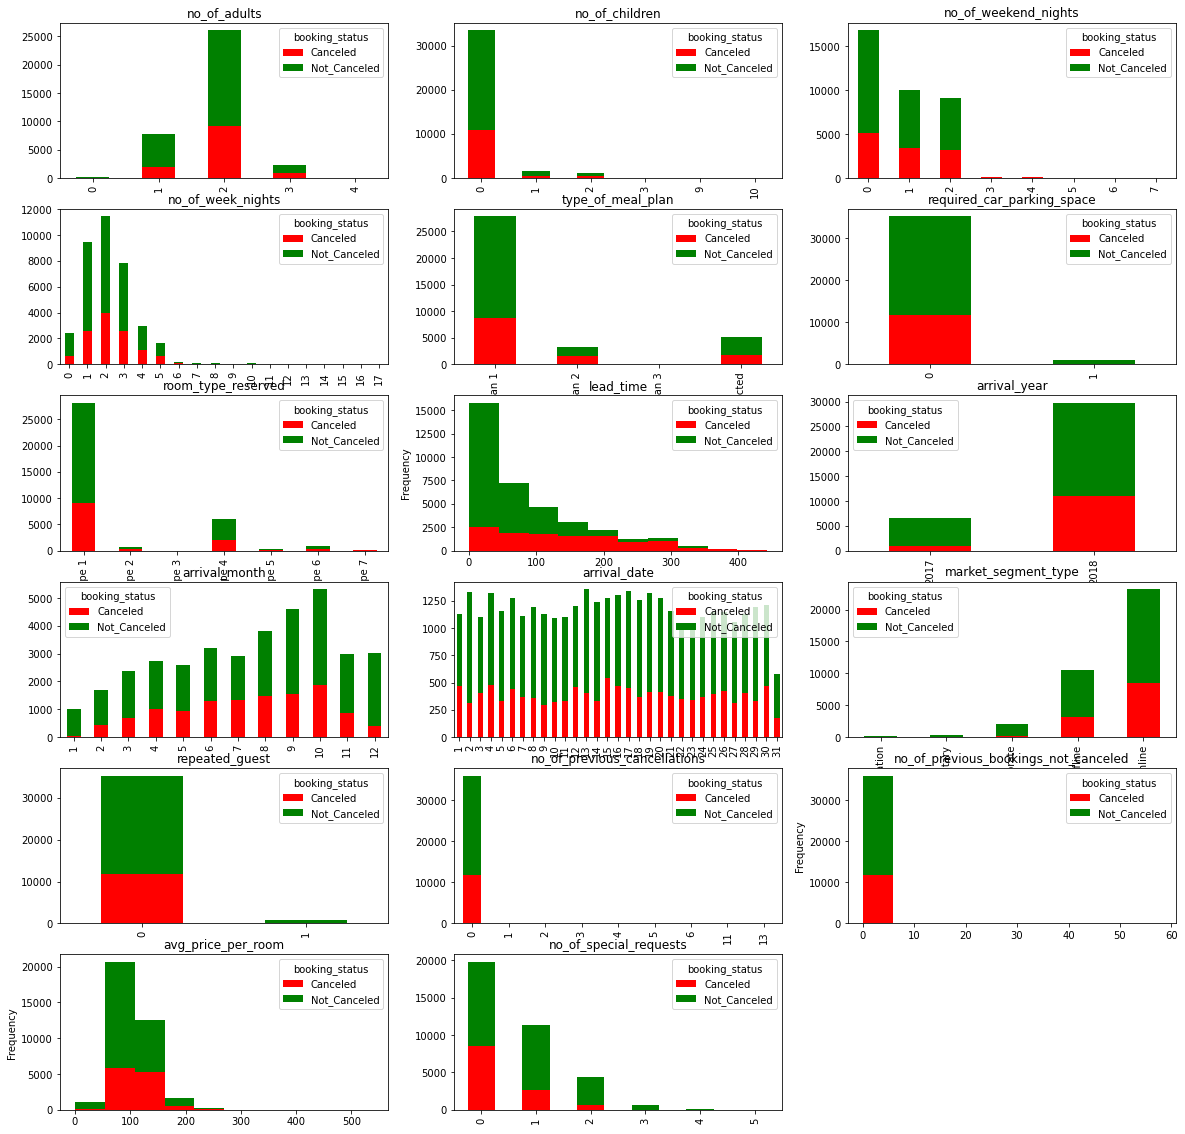

In [308]:
plt.figure(figsize=(20, 20))
for i, var in enumerate(data.columns.drop("booking_status"), start=1):
    if var in {"avg_price_per_room", "lead_time", "no_of_previous_bookings_not_canceled"}:
        data.pivot(columns="booking_status")[var].plot.hist(ax=plt.subplot(6, 3, i), title=var, stacked=True,
                                                            color=["r", "g"])
    else:
        data.groupby([var, "booking_status"]).size().unstack("booking_status").plot.bar(ax=plt.subplot(6, 3, i), title=var,
                                                                                stacked=True, color=["r", "g"], xlabel="")

Mentre per le altre variabili ad occhio non si notano trend significativi, nei grafici della variabili lead_time e no_of_special_requests si possono notare due trend interessanti:
- all'aumentare del lead_time, la percentuale delle prenotazioni cancellate aumenta; questo sembra essere coerente con le aspettative, in quanto prenotando molto in anticipo è più probabile che ci siano imprevisti e si debba cancellare la prenotazione, rispetto al prenotare qualche giorno o qualche decina di giorni prima
- all'aumentare del no_of_special_requests, la percentuale delle prenotazioni cancellate diminuisce; anche questo sembra essere coerente con le aspettative, in quanto chiedere molte richieste speciali fa pensare a una prenotazione con più "impegno" rispetto ad una prenotazione con 0 (o poche) richieste, che fa pensare a una prenotazione "fatta di fretta" e magari con l'idea di cancellarla successivamente.

Si presuppone quindi un'importanza elevata delle variabili lead_time e no_of_special_requests.

### Cancellazione dati

In un'esplorazione successiva è stato notato che è presente come data il 29 febbraio 2018. Questo è sicuramente un errore nei dati in quanto tale data non esiste. Di conseguenza si procede eliminando le relative righe dal dataframe.

In [309]:
data = data.drop(data.loc[(data["arrival_year"] == 2018) & (data["arrival_month"] == 2) & (data["arrival_date"] == 29)].index)

### Analisi delle relazioni tra feature

Andiamo ora ad analizzare le relazioni tra le feature.

Partiamo col fare un esempio visualizzando un grafico a dispersione che mette in relazione avg_price_per_room con lead_time.

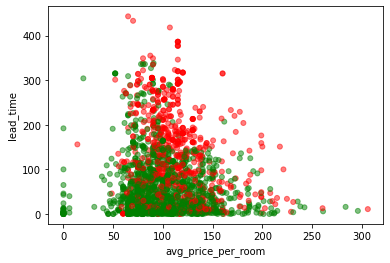

In [317]:
sample = data.sample(2000)
sample.plot.scatter(
    "avg_price_per_room",
    "lead_time",
    alpha=0.5,
    s=25,
    c=sample["booking_status"].map(booking_status_colors)
);

Visualizziamo ora le relazioni tra ogni coppia di feature sempre attraverso i grafici a dispersione.

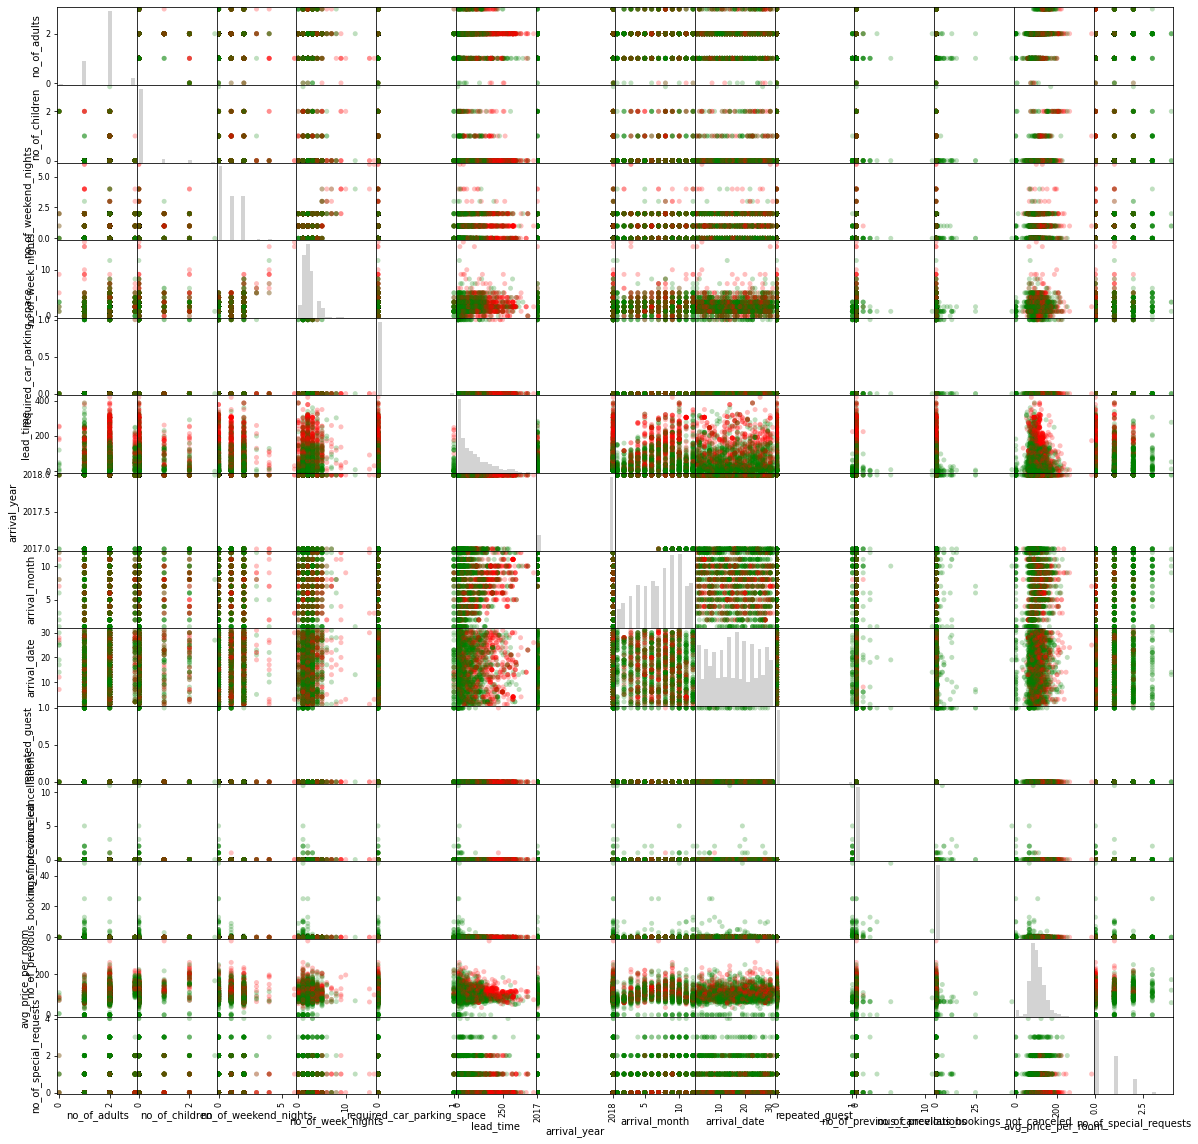

In [318]:
sample = data.sample(2000)
_ = pd.plotting.scatter_matrix(#sample[["avg_price_per_room", "lead_time", "no_of_previous_bookings_not_canceled"]],
                               sample.drop(["booking_status"], axis=1), 
                               c=sample["booking_status"].map(booking_status_colors),
                               alpha=0.25,
                               figsize=(20, 20), 
                               marker="o",
                               s=25,
                               hist_kwds={"bins": 20, "color": "lightgray"})

Cerchiamo di visualizzare meglio le relazioni tra le feature visualizzando una mappa delle correlazioni, che risulta più facilmente leggibile.

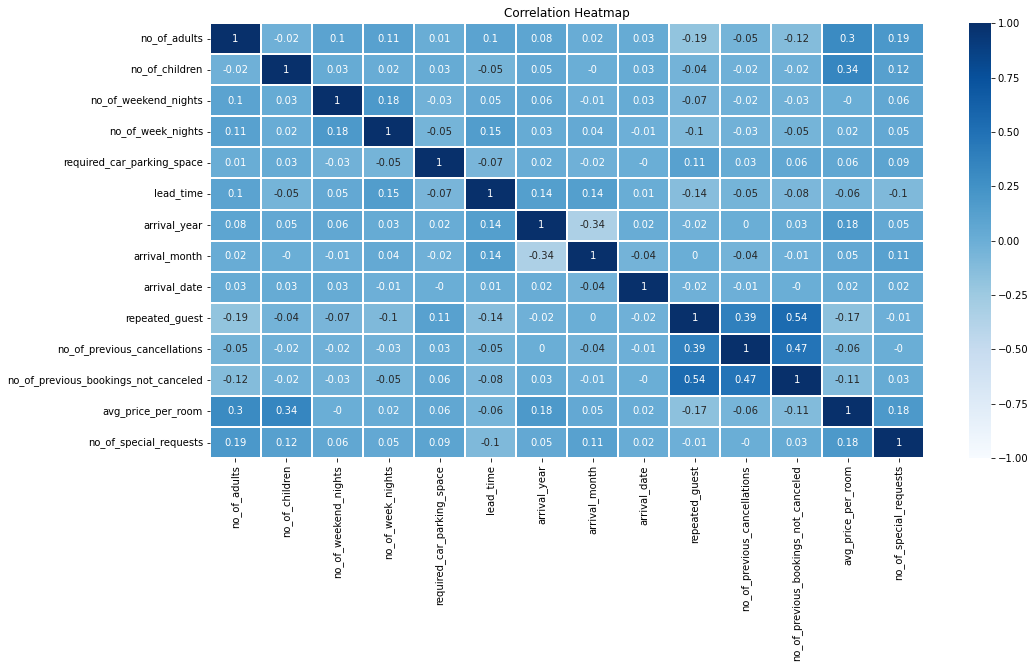

In [319]:
import seaborn as sns
plt.figure(figsize=(16, 8))
corr_matrix = data.corr().round(2)
sns.heatmap(corr_matrix, annot=True, cmap="Blues", linewidths=0.2, fmt=".2g", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

Notiamo che non ci sono correlazioni rilevanti. Sono presenti alcune correlazioni elevate come 0.54 o 0.39 ma sono dovute alla distribuzione dei dati, per tanto risultano irrilevanti.

## Parte 3 - Preparazione dei dati per l'addestramento e la validazione dei modelli di predizione

Come menzionato prima, il dataframe non è ordinato.

L'obiettivo è ora di renderlo ordinato in base alla data di prenotazione, così da poter dividere i dati in training set e test set in ordine temporale, rendendolo realistico. Per fare ciò, si crea una colonna date che rappresenta la data di arrivo formata da anno, mese e giorno presi dalle colonne arrival_year, arrival_month e arrival_date, a cui si sottrae il lead_time, ottenendo così le date di prenotazione. Si imposta quindi la colonna date come indice del dataframe e si ordina in ordine crescente.

In [320]:
pd.to_datetime(data["arrival_year"].astype(str) + "-" +
               data["arrival_month"].astype(str) + "-" +
               data["arrival_date"].astype(str),
               format="%Y-%m-%d")
data["booking_date"] = pd.to_datetime(data["arrival_year"].astype(str) + "-" +
               data["arrival_month"].astype(str) + "-" +
               data["arrival_date"].astype(str),
               format="%Y-%m-%d")
data["booking_date"] = data["booking_date"] - pd.to_timedelta(data["lead_time"], unit='d')
data = data.set_index("booking_date")
data = data.sort_index()

In [321]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
booking_date,,,,,,,,,,,,,,,,,,
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,273,2017,7,17,Online,0,0,0,109.0,0,Canceled
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,257,2017,7,1,Offline,0,0,0,101.5,0,Canceled
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,273,2017,7,17,Online,0,0,0,109.0,0,Canceled
2016-10-17,2,0,0,2,Meal Plan 2,0,Room_Type 1,257,2017,7,1,Online,0,0,0,101.5,0,Canceled
2016-10-17,1,0,0,2,Meal Plan 2,0,Room_Type 1,257,2017,7,1,Offline,0,0,0,80.0,0,Not_Canceled


In [322]:
data.index.value_counts() # DA TOGLIERE

2017-10-02    644
2017-07-06    438
2018-01-03    413
2018-04-04    303
2018-01-06    282
             ... 
2017-02-25      1
2017-02-24      1
2017-02-16      1
2017-02-11      1
2018-12-30      1
Name: booking_date, Length: 635, dtype: int64

A questo punto, si può procedere con le divisioni.

### Divisione delle variabili tra predittive e target

booking_status è la variabile target da predire, dividiamo quindi il dataset come segue.

In [21]:
X = data.drop(columns="booking_status")
y = data["booking_status"]

### Divisione in training set e test set

Dividiamo ora il dataset in training set e test set, prendendo le prime n righe per il training set e le rimanenti per il test set. Viene definita una funzione che si occupa di questo, alla quale occorre passare il parametro per decidere la dimensione del training set.

In [22]:
def split_dataset(X, y, train_size):
    if train_size <= 0 or train_size >= 1:
        raise Exception("Invalid test size")
    pivot = round(len(X) * train_size)
    X_train = X.iloc[:pivot]
    y_train = y.iloc[:pivot]
    X_val = X.iloc[pivot:]
    y_val = y.iloc[pivot:]
    return X_train, y_train, X_val, y_val

In [23]:
X_train, y_train, X_val, y_val = split_dataset(X, y, train_size=0.7)

### Preprocessing

Per usare le variabili categoriche in un modello di predizione, occorre trasformarle in numeriche. Per fare questo utilizziamo il **one-hot encoding**, che converte ogni variabile categorica in n variabili numeriche binarie. Vedremo se e quanto queste variabili saranno rilevanti successivamente.

Prepariamo quindi un transformer e una griglia per trattare diversamente ogni tipo di variabile, ovvero:
- le variabili numeriche rimangono invariate o si usa lo standard scaling
- le variabili categoriche si ignorano o si usa il one-hot encoding
- le variabili binarie si lasciano invariate in quanto non è necessaria nessuna operazione di pre-processing

In [247]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # usato successivamente

transformer = ColumnTransformer([
    ("numeric",     ...,           numeric_vars),
    ("categorical", ...,           categorical_vars),
    ("binary",      "passthrough", binary_vars)
])

preproc_grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__categorical": ["drop", OneHotEncoder(drop=None), OneHotEncoder(drop="first")]
    #"preproc__categorical__drop": [None, "first"]
}

## Parte 4 - Addestramento e validazione di modelli

Saranno utilizzati i seguenti modelli di classificazione: Perceptron, Logistic Regression e Decision Tree. Ogni modello sarà addestrato utilizzando una Grid Search.
Si prepara quindi il codice necessario ad addestrare e validare ogni modello.

Si comincia con l'importazione delle librerie necessarie e col preparare la tupla del pre-processing da inserire nella pipeline di ogni modello.

In [326]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

preproc_tuple = ("preproc", transformer)

Prepariamo le liste necessarie.

In [327]:
names = []
tuples = []
grids = []

Per ogni modello, definiamo la relativa tupla e la relativa griglia, e aggiorniamo le liste.

### Perceptron

In [328]:
from sklearn.linear_model import Perceptron

perceptron_tuple = ("class", Perceptron(n_jobs=-1, random_state=42)) # n_jobs=-1 -> usa tutti i processori
perceptron_grid = {
    "class__penalty": ["l2", "l1", "elasticnet"],
    "class__alpha": np.logspace(-2, 2, 5),
    "class__fit_intercept": [False, True]
}

names.append("Perceptron")
tuples.append(perceptron_tuple)
grids.append(perceptron_grid)

### Logistic Regression

In [329]:
from sklearn.linear_model import LogisticRegression

lr_tuple = ("class", LogisticRegression(solver='saga', random_state=42))
lr_grid = {
    #"lr__fit_intercept": [False, True]   # ??????????????????????????????????????????????
    #{
    #    "penalty": ["l2", "l1"],
    #    "C": [0.1, 1, 10]
    #},
    #{
    #    "penalty": ["elasticnet"],
    #    "C": [0.1, 1, 10],
    #    "l1_ratio": [0.2, 0.5]
    #} 
    "class__penalty": ["l2", "l1", "elasticnet"],
    "class__C": [0.1, 1, 10],
    "class__l1_ratio": [0.2, 0.5]
}

names.append("Logistic Regression")
tuples.append(lr_tuple)
grids.append(lr_grid)

### SVM (Support Vector Machine)

In [330]:
from sklearn.svm import SVC

svm_tuple = ("class", SVC(kernel="linear", random_state=42))
svm_grid = {
    "class__C": [0.1, 1, 10, 100]
    #"class__kernel": ["linear"]
}

names.append("SVM")
tuples.append(svm_tuple)
grids.append(svm_grid)

### Decision Tree

In [331]:
from sklearn.tree import DecisionTreeClassifier

tree_tuple = ("class", DecisionTreeClassifier())
tree_grid = {
    "class__min_samples_split": [2, 3, 4],
    "class__min_samples_leaf": [2, 3, 4], 
    "class__max_depth": [3, 5, 7]
}

names.append("Decision Tree")
tuples.append(tree_tuple)
grids.append(tree_grid)

### Random Forest

In [332]:
from sklearn.ensemble import RandomForestClassifier

rforest_tuple = ("class", RandomForestClassifier(n_jobs=-1, random_state=42))
rforest_grid = {
    "class__n_estimators": [6, 8, 10],
    "class__min_samples_split": [2, 3, 4],
    "class__max_depth": [3, 5, 7]
}

names.append("Random Forest")
tuples.append(rforest_tuple)
grids.append(rforest_grid)

Aggiorniamo models e grids.

In [333]:
models = [Pipeline([preproc_tuple, t]) for t in tuples]
grids = [dict(preproc_grid, **g) for g in grids]

Addestriamo e valutiamo tutti i modelli definiti.

In [334]:
%%time

gs_list = []
train_scores = []
val_scores = []
skf = StratifiedKFold(3, shuffle=True, random_state=42)
for i in range(len(names)):
    gs = GridSearchCV(models[i], grids[i], cv=skf)
    gs.fit(X_train, y_train)
    gs_list.append(gs)
    train_scores.append(gs.score(X_train, y_train))
    val_scores.append(gs.score(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

Wall time: 1h 5min 3s


Creiamo una funzione che restituisce una lista delle feature attuali utilizzate dai modelli. Le variabili "modificate" saranno quelle categoriche che il one-hot encoder ha suddiviso in più variabili.

In [335]:
def get_features(gs):
    features = []
    t = gs.best_estimator_.named_steps["preproc"]
    categ_names = t.named_transformers_["categorical"].get_feature_names().tolist()
    i_var, i_list = 0, 0
    for var in X.columns:
        if var not in categorical_vars:
            features.append(var)
        else:
            while i_list < len(categ_names) and int(categ_names[i_list][1]) == i_var:
                features.append(var + categ_names[i_list][2:])
                i_list = i_list + 1
            i_var = i_var + 1
    return features

### Confronto dei modelli addestrati

Visualizziamo ora nel dettaglio cosa si evince dai modelli addestrati, ovvero gli iperparametri migliori e le variabili del dataframe più significative.

In [338]:
from IPython.display import display  # to print more dataframes in one cell
from sklearn.tree import export_text # to print the rules of a decision tree

for i in range(len(names)):
    print(names[i] + ":\t\tTraining score:", train_scores[i], "\tValidation score:", val_scores[i])
    display(pd.DataFrame(gs_list[i].cv_results_).sort_values("rank_test_score").head(3))  #print(gs_list[i].best_params_)
    try:
        getattr(gs_list[i].best_estimator_.named_steps["class"], "coef_")
        print("Params:")
        #print(gs_list[i].best_estimator_.named_steps["class"].coef_)
        print(pd.Series(gs_list[i].best_estimator_.named_steps["class"].coef_[0], index=get_features(gs_list[i])))
    except AttributeError: # Random Forest
        try:
            getattr(gs_list[i].best_estimator_.named_steps["class"], "estimators_")
            print(export_text(gs_list[i].best_estimator_.named_steps["class"].estimators_[0], max_depth=3,
                          feature_names=get_features(gs_list[i])))
        except AttributeError:
            print(export_text(gs_list[i].best_estimator_.named_steps["class"], max_depth=3,
                          feature_names=get_features(gs_list[i])))
            #plot_tree(model, feature_names=X2d_train.columns.to_list());
    if i != len(names) - 1:
        print("\n\n")

Perceptron:		Training score: 0.7461662790239287 	Validation score: 0.7722380645754761


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__alpha,param_class__fit_intercept,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,0.169714,0.027528,0.072522,0.004359,0.01,True,l1,OneHotEncoder(),StandardScaler(),"{'class__alpha': 0.01, 'class__fit_intercept':...",0.796831,0.752365,0.748788,0.765995,0.021853,1
24,0.154251,0.037601,0.053294,0.000553,0.01,True,l1,drop,passthrough,"{'class__alpha': 0.01, 'class__fit_intercept':...",0.759816,0.752720,0.759077,0.757204,0.003185,2
8,0.179812,0.016346,0.068805,0.012238,0.01,False,l1,OneHotEncoder(),passthrough,"{'class__alpha': 0.01, 'class__fit_intercept':...",0.757450,0.753666,0.750917,0.754011,0.002679,3


Params:
no_of_adults                            0.000000
no_of_children                          0.000000
no_of_weekend_nights                    0.000000
no_of_week_nights                       0.000000
type_of_meal_plan_Meal Plan 1          -1.682727
type_of_meal_plan_Meal Plan 2           0.000000
type_of_meal_plan_Meal Plan 3           0.000000
type_of_meal_plan_Not Selected          0.000000
required_car_parking_space              0.000000
room_type_reserved_Room_Type 1          0.000000
room_type_reserved_Room_Type 2          0.000000
room_type_reserved_Room_Type 3          0.000000
room_type_reserved_Room_Type 4          0.000000
room_type_reserved_Room_Type 5          0.000000
room_type_reserved_Room_Type 6          0.000000
room_type_reserved_Room_Type 7          0.000000
lead_time                               0.000000
arrival_year                            0.000000
arrival_month                           0.000000
arrival_date                            0.000000
market_segme

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,0.773080,0.014566,0.022314,0.001253,0.1,0.2,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.809603,0.799669,0.797871,0.802381,0.005159,1
27,0.792056,0.014371,0.022666,0.001700,0.1,0.5,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.809603,0.799669,0.797871,0.802381,0.005159,1
35,0.749472,0.008862,0.023702,0.000995,0.1,0.5,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.809957,0.799196,0.797635,0.802263,0.005478,3


Params:
no_of_adults                           -0.095623
no_of_children                         -0.019381
no_of_weekend_nights                   -0.114904
no_of_week_nights                      -0.046649
type_of_meal_plan_Meal Plan 1          -1.464703
type_of_meal_plan_Meal Plan 2          -0.138414
type_of_meal_plan_Meal Plan 3           0.216296
type_of_meal_plan_Not Selected         -0.012999
required_car_parking_space             -0.019746
room_type_reserved_Room_Type 1          0.247941
room_type_reserved_Room_Type 2         -0.705130
room_type_reserved_Room_Type 3          1.071419
room_type_reserved_Room_Type 4          0.124394
room_type_reserved_Room_Type 5          0.000000
room_type_reserved_Room_Type 6          0.000000
room_type_reserved_Room_Type 7          0.000000
lead_time                              -0.387494
arrival_year                            0.000000
arrival_month                           0.000000
arrival_date                            0.000000
market_segme

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,7.812215,0.153139,2.035617,0.053666,0.1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 0.1, 'preproc__categorical': OneH...",0.813860,0.800970,0.799054,0.804628,0.006575,1
3,7.956495,0.172576,2.067304,0.024229,0.1,OneHotEncoder(),StandardScaler(),"{'class__C': 0.1, 'preproc__categorical': OneH...",0.813505,0.799196,0.799054,0.803918,0.006779,2
11,11.618163,0.146457,2.023448,0.046937,1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'preproc__categorical': OneHot...",0.812204,0.798605,0.799763,0.803524,0.006156,3


Params:
no_of_adults                           -0.113088
no_of_children                         -0.044853
no_of_weekend_nights                   -0.046227
no_of_week_nights                      -0.055260
type_of_meal_plan_Meal Plan 2          -1.090155
type_of_meal_plan_Meal Plan 3          -0.163677
type_of_meal_plan_Not Selected          0.111989
required_car_parking_space             -0.035034
room_type_reserved_Room_Type 2         -0.032148
room_type_reserved_Room_Type 3          0.114318
room_type_reserved_Room_Type 4         -0.547961
room_type_reserved_Room_Type 5          0.823637
room_type_reserved_Room_Type 6         -0.296408
room_type_reserved_Room_Type 7         -0.100000
lead_time                              -0.068240
arrival_year                            0.211254
arrival_month                          -0.100000
arrival_date                            0.222652
market_segment_type_Complementary       0.333253
market_segment_type_Corporate           0.646219
market_segme

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__max_depth,param_class__min_samples_leaf,param_class__min_samples_split,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
118,0.062669,0.001675,0.020331,0.000472,7,2,3,OneHotEncoder(drop='first'),passthrough,"{'class__max_depth': 7, 'class__min_samples_le...",0.865066,0.858207,0.86162,0.861631,0.002800,1
119,0.068332,0.000471,0.022000,0.000001,7,2,3,OneHotEncoder(drop='first'),StandardScaler(),"{'class__max_depth': 7, 'class__min_samples_le...",0.864948,0.858089,0.86162,0.861552,0.002801,2
122,0.060666,0.000945,0.019004,0.000003,7,2,4,OneHotEncoder(),passthrough,"{'class__max_depth': 7, 'class__min_samples_le...",0.864948,0.858089,0.86162,0.861552,0.002801,2


|--- type_of_meal_plan_Meal Plan 2 <= 151.50
|   |--- room_type_reserved_Room_Type 5 <= 0.50
|   |   |--- no_of_previous_bookings_not_canceled <= 0.50
|   |   |   |--- type_of_meal_plan_Meal Plan 2 <= 90.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- type_of_meal_plan_Meal Plan 2 >  90.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- no_of_previous_bookings_not_canceled >  0.50
|   |   |   |--- type_of_meal_plan_Meal Plan 2 <= 13.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- type_of_meal_plan_Meal Plan 2 >  13.50
|   |   |   |   |--- truncated branch of depth 4
|   |--- room_type_reserved_Room_Type 5 >  0.50
|   |   |--- type_of_meal_plan_Meal Plan 2 <= 61.50
|   |   |   |--- no_of_week_nights <= 4.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- no_of_week_nights >  4.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- type_of_meal_plan_Meal Plan 2 >  61.50
|   |   |   |--- type_of_meal_plan_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__max_depth,param_class__min_samples_split,param_class__n_estimators,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
160,0.186306,0.000495,0.046041,0.000674,7,4,10,OneHotEncoder(drop='first'),passthrough,"{'class__max_depth': 7, 'class__min_samples_sp...",0.861518,0.849338,0.841750,0.850869,0.008143,1
161,0.190144,0.007193,0.038109,0.006555,7,4,10,OneHotEncoder(drop='first'),StandardScaler(),"{'class__max_depth': 7, 'class__min_samples_sp...",0.861400,0.849338,0.841750,0.850829,0.008091,2
154,0.173596,0.001825,0.043965,0.001134,7,4,8,OneHotEncoder(drop='first'),passthrough,"{'class__max_depth': 7, 'class__min_samples_sp...",0.862228,0.848628,0.834772,0.848543,0.011209,3


|--- type_of_meal_plan_Meal Plan 3 <= 2017.50
|   |--- type_of_meal_plan_Not Selected <= 7.50
|   |   |--- no_of_children <= 0.50
|   |   |   |--- no_of_previous_cancellations <= 0.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- no_of_previous_cancellations >  0.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- no_of_children >  0.50
|   |   |   |--- no_of_week_nights <= 3.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- no_of_week_nights >  3.50
|   |   |   |   |--- truncated branch of depth 2
|   |--- type_of_meal_plan_Not Selected >  7.50
|   |   |--- type_of_meal_plan_Not Selected <= 10.50
|   |   |   |--- room_type_reserved_Room_Type 6 <= 0.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- room_type_reserved_Room_Type 6 >  0.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- type_of_meal_plan_Not Selected >  10.50
|   |   |   |--- room_type_reserved_Room_Type 4 <= 72.24
|   |   |   |   |--- truncated branch of

Si nota che:
- il modello che ha ottenuto lo score migliore è il Random Forest (0.82)
- nessun modello sembra andare in overfitting; Decision Tree e Random Forest sono gli unici ad avere uno score maggiore sul training set, ma con differenze abbastanze contenute (0.05 e 0.03)
- lo standard scaler risulta efficace quasi sempre; uniche eccezioni le fanno il Decision Tree e il Random Forest, i quali ne restano abbastanza indifferenti (come d'altronde ci si poteva aspettare, date le caratteristiche dei decision tree)
- il one-hot encoder dà invece in tutti i modelli i risultati migliori
- le variabili più significative fra tutti i modelli addestrati sembrano quindi essere no_of_previous_bookings_not_canceled, type_of_meal_plan e room_type_reserved

### Ulteriori metriche: precision, recall e F1-measure

Si creano due funzioni per stampare matrice di confusione e metriche (precision, recall e F1-measure) di ogni modello.

In [339]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer

def show_info(gs):
    y_pred = gs.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    print("Matrice di confusione:")
    display(pd.DataFrame(cm, index=gs.classes_, columns=gs.classes_))
    print("Precision: ", precision_score(y_val, y_pred, pos_label="Canceled"))
    print("Recall:    ", recall_score(y_val, y_pred, pos_label="Canceled"))
    print("F1-measure:", f1_score(y_val, y_pred, pos_label="Canceled"))

def show_all_info(gs_list):
    for i, gs in enumerate(gs_list):
        print(names[i] + ":\n")
        show_info(gs)
        if i != len(gs_list) - 1:
            print("\n\n\n")

Confrontiamo quindi i modelli addestrati.

In [340]:
show_all_info(gs_list)

Perceptron:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,322,2257
Not_Canceled,219,8073


Precision:  0.5951940850277264
Recall:     0.12485459480418767
F1-measure: 0.2064102564102564




Logistic Regression:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,942,1637
Not_Canceled,490,7802


Precision:  0.6578212290502793
Recall:     0.36525785188057386
F1-measure: 0.4697083021690351




SVM:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,969,1610
Not_Canceled,558,7734


Precision:  0.6345776031434185
Recall:     0.37572702597906166
F1-measure: 0.47199220652703355




Decision Tree:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,869,1710
Not_Canceled,345,7947


Precision:  0.7158154859967051
Recall:     0.33695230709577356
F1-measure: 0.4582124967044556




Random Forest:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,1233,1346
Not_Canceled,586,7706


Precision:  0.6778449697636064
Recall:     0.4780922838309422
F1-measure: 0.5607094133697135


Osserviamo che i modelli addestrati sono meno buoni di quello che si pensava. Ricordiamo che le classi non sono bilanciate (circa 2/3 Not_Canceled, 1/3 Canceled). Questo comporta che un algoritmo che predirrebbe sempre la classe Not_Canceled avrebbe un'accuratezza del 67% circa, che è lontano, ma neanche troppo, dai risultati sopra ottenuti (82% il Random Forest). Mettiamo quindi da parte l'accuracy e concentriamoci sulla F1-measure, che con classi sbilanciate è la scelta migliore.

Riaddestriamo quindi tutti i modelli massimizzando la F1-measure.

In [ ]:
%%time

gs_list_f1 = []
f1_scores = []
my_f1_score = make_scorer(f1_score, pos_label="Canceled")
for i in range(len(names)):
    gs = GridSearchCV(models[i], grids[i], cv=skf, scoring=my_f1_score)
    gs.fit(X_train, y_train)
    gs_list_f1.append(gs)
    f1_scores.append(gs.score(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

Rivisualizziamo il confronto tra i modelli.

In [150]:
for i in range(len(names)):
    print(names[i] + ":\t\tScore: " + f1_scores[i].astype(str))
    display(pd.DataFrame(gs_list_f1[i].cv_results_).sort_values("rank_test_score").head(3))  #print(gs_list[i].best_params_)
    try:
        getattr(gs_list_f1[i].best_estimator_.named_steps["class"], "coef_")
        print("Params:")
        print(pd.Series(gs_list_f1[i].best_estimator_.named_steps["class"].coef_[0], index=get_features(gs_list_f1[i])))
    except AttributeError:
        # nodi dei primi livelli
        print(export_text(gs_list_f1[i].best_estimator_.named_steps["class"], max_depth=3,
                          feature_names=get_features(gs_list_f1[i])))
        #plot_tree(model, feature_names=X2d_train.columns.to_list());
    print("\n\n")

Perceptron:		Score: 0.3633581110625273


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__alpha,param_class__fit_intercept,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,0.244826,0.038757,0.197806,0.009928,0.01,False,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__alpha': 0.01, 'class__fit_intercept':...",0.686238,0.696705,0.624463,0.669135,0.031876,1
27,0.200074,0.057364,0.223469,0.036617,0.01,True,l1,OneHotEncoder(),StandardScaler(),"{'class__alpha': 0.01, 'class__fit_intercept':...",0.688316,0.660836,0.650773,0.666642,0.015867,2
7,0.119035,0.021833,0.176677,0.002421,0.01,False,l1,drop,StandardScaler(),"{'class__alpha': 0.01, 'class__fit_intercept':...",0.606757,0.642682,0.646672,0.632037,0.017950,3


Params:
no_of_adults                            0.000000
no_of_children                          0.000000
no_of_weekend_nights                   -0.957385
no_of_week_nights                       0.000000
type_of_meal_plan_Meal Plan 2          -1.484899
type_of_meal_plan_Meal Plan 3           0.000000
type_of_meal_plan_Not Selected          0.000000
required_car_parking_space              0.000000
room_type_reserved_Room_Type 2          0.000000
room_type_reserved_Room_Type 3          0.000000
room_type_reserved_Room_Type 4          0.000000
room_type_reserved_Room_Type 5          0.110825
room_type_reserved_Room_Type 6          0.000000
room_type_reserved_Room_Type 7          0.000000
lead_time                               0.000000
arrival_year                            0.000000
arrival_month                           0.000000
arrival_date                            0.000000
market_segment_type_Complementary       0.000000
market_segment_type_Corporate           0.000000
market_segme

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,2.694404,0.304353,0.199368,0.007554,0.1,0.5,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.727488,0.713464,0.710976,0.717309,0.007269,1
9,2.127443,0.008204,0.197230,0.007276,0.1,0.2,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.727488,0.713464,0.710976,0.717309,0.007269,1
35,2.072536,0.010534,0.189481,0.012162,0.1,0.5,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.727581,0.713079,0.710540,0.717066,0.007507,3


Params:
no_of_adults                           -0.095623
no_of_children                         -0.019381
no_of_weekend_nights                   -0.114904
no_of_week_nights                      -0.046649
type_of_meal_plan_Meal Plan 1          -1.464703
type_of_meal_plan_Meal Plan 2          -0.138414
type_of_meal_plan_Meal Plan 3           0.216296
type_of_meal_plan_Not Selected         -0.012999
required_car_parking_space             -0.019746
room_type_reserved_Room_Type 1          0.247941
room_type_reserved_Room_Type 2         -0.705130
room_type_reserved_Room_Type 3          1.071419
room_type_reserved_Room_Type 4          0.124394
room_type_reserved_Room_Type 5          0.000000
room_type_reserved_Room_Type 6          0.000000
room_type_reserved_Room_Type 7          0.000000
lead_time                              -0.387494
arrival_year                            0.000000
arrival_month                           0.000000
arrival_date                            0.000000
market_segme

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__max_depth,param_class__min_samples_leaf,param_class__min_samples_split,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
46,0.223612,0.003343,0.147105,0.001055,None,4,3,OneHotEncoder(drop='first'),passthrough,"{'class__max_depth': None, 'class__min_samples...",0.847249,0.823322,0.832355,0.834309,0.009865,1
52,0.224074,0.005668,0.147133,0.000775,None,4,4,OneHotEncoder(drop='first'),passthrough,"{'class__max_depth': None, 'class__min_samples...",0.847383,0.821137,0.832434,0.833651,0.010749,2
28,0.229651,0.002593,0.147356,0.000887,None,3,3,OneHotEncoder(drop='first'),passthrough,"{'class__max_depth': None, 'class__min_samples...",0.842322,0.824158,0.832292,0.832924,0.007429,3


|--- type_of_meal_plan_Meal Plan 2 <= 151.50
|   |--- room_type_reserved_Room_Type 5 <= 0.50
|   |   |--- no_of_previous_bookings_not_canceled <= 0.50
|   |   |   |--- type_of_meal_plan_Meal Plan 2 <= 90.50
|   |   |   |   |--- truncated branch of depth 18
|   |   |   |--- type_of_meal_plan_Meal Plan 2 >  90.50
|   |   |   |   |--- truncated branch of depth 12
|   |   |--- no_of_previous_bookings_not_canceled >  0.50
|   |   |   |--- type_of_meal_plan_Meal Plan 2 <= 13.50
|   |   |   |   |--- truncated branch of depth 21
|   |   |   |--- type_of_meal_plan_Meal Plan 2 >  13.50
|   |   |   |   |--- truncated branch of depth 26
|   |--- room_type_reserved_Room_Type 5 >  0.50
|   |   |--- type_of_meal_plan_Meal Plan 2 <= 61.50
|   |   |   |--- no_of_week_nights <= 4.50
|   |   |   |   |--- truncated branch of depth 25
|   |   |   |--- no_of_week_nights >  4.50
|   |   |   |   |--- truncated branch of depth 12
|   |   |--- type_of_meal_plan_Meal Plan 2 >  61.50
|   |   |   |--- type_of_meal

In [235]:
show_all_info(gs_list_f1)

Perceptron:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,831,1748
Not_Canceled,1164,7128


Precision:  0.41654135338345866
Recall:     0.32221791392012405
F1-measure: 0.3633581110625273




Logistic Regression:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,942,1637
Not_Canceled,490,7802


Precision:  0.6578212290502793
Recall:     0.36525785188057386
F1-measure: 0.4697083021690351




Decision Tree:

Matrice di confusione:


,Canceled,Not_Canceled
Canceled,941,1638
Not_Canceled,713,7579


Precision:  0.5689238210399032
Recall:     0.36487010469174097
F1-measure: 0.44460193716040636


Notiamo un significativo miglioramento per il modello Perceptron. Differenza irrilevante invece per gli altri modelli.

Logistic Regression rimane comunque il miglior modello. # TO MODIFY

In [35]:
# PROVA COEF CON PERCEPTRON
from IPython.display import display  # to display more dataframes in one cell

model_perc = Pipeline([
    #("preproc", ColumnTransformer([
        #("numeric",     StandardScaler(), numeric_vars),
        #("categorical", OneHotEncoder(),  categorical_vars),
        #("binary",      "passthrough",    binary_vars)
    #])),
    preproc_tuple,
    ("class", Perceptron(random_state=42)) #LogisticRegression(solver='saga', random_state=42))
])

# SEMPLICE - FUNZIONA
#model_perc.fit(X_train, y_train)
#print(model_perc.named_steps["class"].coef_[0])

gs = GridSearchCV(model_perc, preproc_grid, cv=outer_cv)
gs.fit(X_train, y_train)
print(gs.best_estimator_.named_steps["class"].coef_)
display(pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5))

##model.score(X_val, y_val)
##print(model_ex.named_steps["class"].coef_[0])
##pd.Series(model.named_steps["class"].coef_[0], index=X.columns)

NameError: name 'outer_cv' is not defined

## Parte 5 - Modello migliore e conclusioni

Si è trovato quindi che l'algoritmo migliore per il problema di classificazione considerato è quello della Logistic Regression. # TO MODIFY

In [167]:
index_of_best_model = np.argmax(f1_scores)
best_model = Pipeline([preproc_tuple, tuples[index_of_best_model]])
best_model_grid = dict(preproc_grid, **grids[index_of_best_model])

### Nested cross-validation

Vogliamo ora riaddestrare l'algoritmo utilizzando anche una Nested cross-validation. Definiamo la relativa funzione.

In [255]:
# DA TOGLIERE PARTE COMMENTATA ROSSAAAAAAA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# StratifiedKFold è una variante di KFold che garantisce uguale distribuzione delle classi tra un fold e l'altro, cosa
# che risulta fondamentale trattandosi di una classificazione
"""
skf = StratifiedKFold(3, shuffle=True, random_state=42)

gs = GridSearchCV(model, grid, cv=skf)

#from sklearn.model_selection import cross_validate
#cv_result = cross_validate(model, X, y, cv=kf, return_train_score=True)

# nested cross validation
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        results.append(gs.score(X_val, y_val))
    return results
"""
# nested cross validation
outer_cv = StratifiedKFold(3, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(5, shuffle=True, random_state=42)
def nested_cv(model, grid):
    #print("\n\n\nModel:\n")
    gs_list = []
    f1_scores = []
    accuracies = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv, scoring=my_f1_score)
        gs.fit(X_train, y_train)
        gs_list.append(gs)
        f1_scores.append(gs.score(X_val, y_val))
        accuracies.append(accuracy_score(y_val, gs.predict(X_val)))
        
        print("Best params:\n")
        print(gs.best_params_)
        print("Ranks:\n")
        display(pd.DataFrame(gs.cv_results_).sort_values("rank_test_score"))
    return gs_list[np.argmax(results)], max(f1_scores), max(accuracies)

Addestriamo quindi l'algoritmo.

In [256]:
%%time
best_gs, best_f1_score, best_accuracy = nested_cv(best_model, best_model_grid)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_it

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best params:

{'class__C': 1, 'class__l1_ratio': 0.2, 'class__penalty': 'l1', 'preproc__categorical': OneHotEncoder(drop='first'), 'preproc__numeric': StandardScaler()}
Ranks:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,0.895039,0.013437,0.036846,0.003677,1,0.5,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.686415,0.681199,0.674649,0.677862,0.667358,0.677497,0.006392,1
47,0.882596,0.004253,0.034726,0.002413,1,0.2,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.686415,0.681199,0.674649,0.677862,0.667358,0.677497,0.006392,1
59,0.722374,0.012367,0.037989,0.003293,1,0.5,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.685286,0.681199,0.675103,0.677862,0.667819,0.677454,0.005897,3
41,0.704551,0.008082,0.033918,0.000489,1,0.2,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.685286,0.681199,0.675103,0.677862,0.667819,0.677454,0.005897,3
53,0.955843,0.033963,0.034791,0.002210,1,0.2,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.685286,0.681199,0.675334,0.677408,0.667819,0.677409,0.005877,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.563665,0.004234,0.031547,0.003158,1,0.2,l1,drop,passthrough,"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94
36,0.476430,0.017926,0.030937,0.003547,1,0.2,l2,drop,passthrough,"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94
18,0.476432,0.017123,0.028590,0.002455,0.1,0.5,l2,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94
90,0.428945,0.010206,0.029792,0.002774,10,0.5,l2,drop,passthrough,"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_it

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best params:

{'class__C': 1, 'class__l1_ratio': 0.2, 'class__penalty': 'l2', 'preproc__categorical': OneHotEncoder(), 'preproc__numeric': StandardScaler()}
Ranks:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,0.729000,0.015749,0.034590,0.003724,1,0.2,l2,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.692204,0.666892,0.673044,0.693143,0.665526,0.678162,0.012120,1
57,0.751512,0.026755,0.038397,0.003774,1,0.5,l2,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.692204,0.666892,0.673044,0.693143,0.665526,0.678162,0.012120,1
69,1.130882,0.076047,0.035828,0.003206,1,0.5,elasticnet,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.692204,0.666442,0.672591,0.693587,0.665753,0.678115,0.012308,3
45,0.933806,0.019819,0.034790,0.001832,1,0.2,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.691765,0.665991,0.672821,0.693587,0.666210,0.678075,0.012185,4
63,0.922758,0.017001,0.034989,0.004482,1,0.5,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.691765,0.665991,0.672821,0.693587,0.666210,0.678075,0.012185,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,0.439509,0.007280,0.030997,0.002502,1,0.2,l2,drop,passthrough,"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.585821,0.555215,0.563465,0.571864,0.560863,0.567446,0.010639,91
30,0.535273,0.012876,0.028994,0.002535,0.1,0.5,elasticnet,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.585821,0.555215,0.563465,0.571864,0.560863,0.567446,0.010639,91
90,0.435477,0.004391,0.031188,0.002978,10,0.5,l2,drop,passthrough,"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.585821,0.555215,0.563465,0.571864,0.560863,0.567446,0.010639,91
6,0.544310,0.013942,0.026980,0.000021,0.1,0.2,l1,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.585293,0.555428,0.563253,0.572301,0.560863,0.567427,0.010464,107


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_it

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best params:

{'class__C': 10, 'class__l1_ratio': 0.2, 'class__penalty': 'l2', 'preproc__categorical': OneHotEncoder(drop='first'), 'preproc__numeric': StandardScaler()}
Ranks:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
95,0.684382,0.018404,0.032799,0.001137,10,0.5,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.687267,0.681140,0.686992,0.681140,0.674219,0.682151,0.004787,1
77,0.683802,0.023200,0.036198,0.003310,10,0.2,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.2, 'clas...",0.687267,0.681140,0.686992,0.681140,0.674219,0.682151,0.004787,1
107,0.894775,0.022860,0.035175,0.002835,10,0.5,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.687267,0.681140,0.686992,0.681140,0.673988,0.682105,0.004864,3
101,0.960354,0.045051,0.037985,0.005334,10,0.5,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.687267,0.681140,0.686992,0.681140,0.673988,0.682105,0.004864,3
89,0.892539,0.011229,0.033389,0.002066,10,0.2,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.2, 'clas...",0.687267,0.681140,0.686992,0.681140,0.673988,0.682105,0.004864,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.447255,0.014205,0.030599,0.003199,10,0.5,l2,drop,passthrough,"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.582987,0.568493,0.573042,0.555935,0.568079,0.569707,0.008732,91
0,0.454887,0.013098,0.031420,0.005555,0.1,0.2,l2,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.582987,0.568493,0.573042,0.555935,0.568079,0.569707,0.008732,91
6,0.535683,0.013482,0.030778,0.002046,0.1,0.2,l1,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.583207,0.568493,0.573042,0.555598,0.567537,0.569575,0.008928,106
24,0.527104,0.009659,0.028598,0.001625,0.1,0.5,l1,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.583207,0.568493,0.573042,0.555598,0.567537,0.569575,0.008928,106


Wall time: 21min 39s


In [179]:
#%%time
#best_gss = nested_cv(best_model, best_model_grid)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_it

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best params:

{'class__C': 1, 'class__l1_ratio': 0.2, 'class__penalty': 'l1', 'preproc__categorical': OneHotEncoder(drop='first'), 'preproc__numeric': StandardScaler()}
Ranks:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,2.131778,0.143405,0.081976,0.012010,1,0.5,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.686415,0.681199,0.674649,0.677862,0.667358,0.677497,0.006392,1
47,0.860357,0.025090,0.034394,0.002939,1,0.2,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.686415,0.681199,0.674649,0.677862,0.667358,0.677497,0.006392,1
59,0.674916,0.013286,0.032974,0.002177,1,0.5,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.685286,0.681199,0.675103,0.677862,0.667819,0.677454,0.005897,3
41,0.660350,0.014947,0.033970,0.002604,1,0.2,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.685286,0.681199,0.675103,0.677862,0.667819,0.677454,0.005897,3
53,0.885132,0.020933,0.035460,0.004048,1,0.2,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.685286,0.681199,0.675334,0.677408,0.667819,0.677409,0.005877,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.549846,0.006185,0.029165,0.002475,1,0.2,l1,drop,passthrough,"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94
36,0.423450,0.015544,0.027581,0.001367,1,0.2,l2,drop,passthrough,"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94
18,0.436469,0.013526,0.030193,0.001789,0.1,0.5,l2,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94
90,0.839747,0.025072,0.057190,0.004260,10,0.5,l2,drop,passthrough,"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.588146,0.561524,0.562618,0.566385,0.564815,0.568698,0.009870,94


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_it

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best params:

{'class__C': 1, 'class__l1_ratio': 0.2, 'class__penalty': 'l2', 'preproc__categorical': OneHotEncoder(), 'preproc__numeric': StandardScaler()}
Ranks:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,1.243372,0.073285,0.056798,0.011598,1,0.2,l2,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.692204,0.666892,0.673044,0.693143,0.665526,0.678162,0.012120,1
57,1.153886,0.047968,0.051178,0.002023,1,0.5,l2,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.692204,0.666892,0.673044,0.693143,0.665526,0.678162,0.012120,1
69,2.479114,0.078542,0.092068,0.012815,1,0.5,elasticnet,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.692204,0.666442,0.672591,0.693587,0.665753,0.678115,0.012308,3
45,1.422976,0.025250,0.051636,0.002693,1,0.2,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.691765,0.665991,0.672821,0.693587,0.666210,0.678075,0.012185,4
63,3.407271,0.066708,0.135842,0.010891,1,0.5,l1,OneHotEncoder(),StandardScaler(),"{'class__C': 1, 'class__l1_ratio': 0.5, 'class...",0.691765,0.665991,0.672821,0.693587,0.666210,0.678075,0.012185,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,0.668544,0.014539,0.044589,0.003125,1,0.2,l2,drop,passthrough,"{'class__C': 1, 'class__l1_ratio': 0.2, 'class...",0.585821,0.555215,0.563465,0.571864,0.560863,0.567446,0.010639,91
30,0.807243,0.007806,0.045995,0.004290,0.1,0.5,elasticnet,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.585821,0.555215,0.563465,0.571864,0.560863,0.567446,0.010639,91
90,1.002749,0.032602,0.070469,0.013940,10,0.5,l2,drop,passthrough,"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.585821,0.555215,0.563465,0.571864,0.560863,0.567446,0.010639,91
6,0.827762,0.017993,0.046607,0.005509,0.1,0.2,l1,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.585293,0.555428,0.563253,0.572301,0.560863,0.567427,0.010464,107


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_it

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: Conve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best params:

{'class__C': 10, 'class__l1_ratio': 0.2, 'class__penalty': 'l2', 'preproc__categorical': OneHotEncoder(drop='first'), 'preproc__numeric': StandardScaler()}
Ranks:



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class__C,param_class__l1_ratio,param_class__penalty,param_preproc__categorical,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
95,0.727648,0.041881,0.035384,0.002669,10,0.5,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.687267,0.681140,0.686992,0.681140,0.674219,0.682151,0.004787,1
77,0.679448,0.008675,0.035960,0.003452,10,0.2,l2,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.2, 'clas...",0.687267,0.681140,0.686992,0.681140,0.674219,0.682151,0.004787,1
107,1.007804,0.048987,0.036376,0.002886,10,0.5,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.687267,0.681140,0.686992,0.681140,0.673988,0.682105,0.004864,3
101,0.878169,0.015002,0.034568,0.003672,10,0.5,l1,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.687267,0.681140,0.686992,0.681140,0.673988,0.682105,0.004864,3
89,1.082994,0.038104,0.042597,0.002738,10,0.2,elasticnet,OneHotEncoder(drop='first'),StandardScaler(),"{'class__C': 10, 'class__l1_ratio': 0.2, 'clas...",0.687267,0.681140,0.686992,0.681140,0.673988,0.682105,0.004864,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.503140,0.031560,0.032183,0.003439,10,0.5,l2,drop,passthrough,"{'class__C': 10, 'class__l1_ratio': 0.5, 'clas...",0.582987,0.568493,0.573042,0.555935,0.568079,0.569707,0.008732,91
0,0.932030,0.022241,0.074990,0.007036,0.1,0.2,l2,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.582987,0.568493,0.573042,0.555935,0.568079,0.569707,0.008732,91
6,1.198985,0.047406,0.062820,0.004074,0.1,0.2,l1,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.2, 'cla...",0.583207,0.568493,0.573042,0.555598,0.567537,0.569575,0.008928,106
24,0.545425,0.022452,0.031779,0.003070,0.1,0.5,l1,drop,passthrough,"{'class__C': 0.1, 'class__l1_ratio': 0.5, 'cla...",0.583207,0.568493,0.573042,0.555598,0.567537,0.569575,0.008928,106


Wall time: 32min 10s


Visualizziamo la F1-measure migliore, confrontandola con quella senza nested cross-validation.

In [257]:
#results = [gs.score(X_val, y_val) for gs in gs_list] # TO ERASE
#best_gs = gs_list[np.argmax(results)] # TO ERASE
#best_f1 = max(results) # TO ERASE
print("F1-measure without nested cross-validation:", f1_scores[index_of_best_model])
print("F1-measure with    nested cross-validation:", best_f1_score)

F1-measure without nested cross-validation: 0.4697083021690351
F1-measure with    nested cross-validation: 0.6844718829687291


Si nota come la nested cross-validation abbia fatto una grande differenza.

### Modello finale

Visualizziamo quindi il modello finale.

In [258]:
print("Modello finale: " + names[index_of_best_model])
print("Iperparametri del modello:", best_gs.best_params_)
print("F1-measure:", best_f1_score)
print("Accuracy:  ", best_accuracy)
#show_info(best_gs)

Modello finale: Logistic Regression
Iperparametri del modello: {'class__C': 1, 'class__l1_ratio': 0.2, 'class__penalty': 'l2', 'preproc__categorical': OneHotEncoder(), 'preproc__numeric': StandardScaler()}
F1-measure: 0.6844718829687291
Accuracy:   0.8084278499875818


In [ ]:
# PROVA NESTED CV SU PERCEPTRON - TO ERASEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
perc_model = Pipeline([
    ("preproc", transformer),
    ("perc", Perceptron(n_jobs=-1, random_state=42))
])
perc_grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__categorical__drop": [None, "first"],
    "perc__penalty": ["l2", "l1", "elasticnet"],
    "perc__alpha": np.logspace(-2, 2, 5),
    "perc__fit_intercept": [False, True]
}
results = nested_cv(perc_model, perc_grid)
print(results)